In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import statsmodels.api as sm
import json
import os
# from utils import *
from get_plot_dict import get_plot_dict
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import statsmodels.api as sm
import os


def get_sector_list(start_sector_code):
    df = get_panjiva()
    hscode6_list = [x for x in map(str, df['hscode6'].unique()) if x.startswith(start_sector_code)]
    hscode6_array = [int(i) for i in hscode6_list]
    
    return hscode6_array


def get_max_countries(N, sector_list, output):
    df = get_data(sector_list)

    serie = df[['shpcountry', output]].groupby(['shpcountry']).sum().unstack()
    serie = pd.to_numeric(serie, downcast="integer").sort_values(ascending=False)
    df2 = pd.DataFrame(serie.reset_index(inplace=False))

    df2 = df2.drop(columns=['level_0'])
    df2.columns = ['source', output]
    
    return list(df2[:N]['source'])


def get_panjiva():
    df = pd.read_csv('portof(un)lading/panjivausimport_imputevalue_shippingtime_yq.csv')
    df = df[['gvkey', 'year', 'quarter', 'hscode6', 'shpcountry', 'valueofgoodsusd_new', 'volumeteu', 'weightkg']]

    df = df[df.year>2007]
    
    return df


def get_data(sector_list):
    df = get_panjiva()
    
    df['hscode6_str'] = df['hscode6'].astype(str)
    df['hscode4_str'] = df['hscode6_str'].str.slice(stop=3)
    df['hscode4'] = df['hscode4_str'].astype(int)
    
    df = df[df['hscode6'].isin(sector_list)]
    
    df['qs'] = df['year'].astype(str) +'-Q'+ df['quarter'].astype(str)
    df['date'] = pd.PeriodIndex(df['qs'], freq='Q').to_timestamp()
    
    return df


def get_data_aggr(df, sector_list, country_list, aggr_country=[], aggr_country_name='SAC'):
    if(len(aggr_country)>0): 
        df['source'] = np.where(df['shpcountry'].isin(aggr_country), aggr_country_name, 'Other') 
    if(len(aggr_country)==0): 
        df['source'] = 'Other'
        aggr_country = []

    for country in list(set(country_list).difference(set(aggr_country))):
        df.loc[df['shpcountry']==country, 'source'] = country 
        
    return df


def get_ordered_source(df, output):
    serie = df[['source', output]].groupby(['source']).sum().unstack()
    serie = pd.to_numeric(serie, downcast="integer").sort_values(ascending=False)
    df = pd.DataFrame(serie.reset_index(inplace=False))

    df = df.drop(columns=['level_0'])
    df.columns = ['source', output]

    return df['source']
   

def get_plot_ts(df, output, title, period, aggr_country_name, hp='NO', hp_lambda=100, save_as='plot_name', figsize=[5, 10]):
    
    ordered_source = get_ordered_source(df, output)
    
    df = df[['date', 'year', 'quarter', 'source', output]].groupby(['date', 'year', 'quarter', 'source']).sum().unstack()
    df.columns = df.columns.droplevel(0)
    df.reset_index(inplace=True)
    
    # generate date as Quartil
    df['fecha'] = pd.to_datetime(df['date'], format ='%Y-%m-%d') 
    df = df.drop('date', axis=1)
    df['month'] = pd.DatetimeIndex(df['fecha']).month
    df.loc[df['month']==1, 'month'] = 3
    df.loc[df['month']==4, 'month'] = 6
    df.loc[df['month']==7, 'month'] = 9
    df.loc[df['month']==10, 'month'] = 12
    df['date'] = pd.to_datetime(dict(year=df.year, month=df.month, day=1))
    df = df.drop(['fecha', 'year', 'month', 'quarter'], axis=1)
    
    df = df[df.date>=period[0]]
    df = df[df.date<=period[1]]


    # cm = 1/2.54  # centimeters in inches
    # plt.figure(figsize)

    fig = plt.figure() 
    fig.set_figheight(figsize[0])
    fig.set_figwidth(figsize[1])

    
    for country in ordered_source:        
        if hp=='NO':
            serie = np.array(df[country]).astype(np.double)
            mask = np.isfinite(serie)
            
            plt.plot(df["date"][mask], serie[mask], label=country)
        if hp=='YES':
            cycle, trend = sm.tsa.filters.hpfilter(df[country], hp_lambda)
            df[country+'_hp'] = trend
            
            serie = np.array(df[country+'_hp']).astype(np.double)
            mask = np.isfinite(serie)
            
            plt.plot(df["date"][mask], serie[mask], label=country)
        
    plt.title(title)
    plt.ylabel(output)
    plt.xlabel("Period of time")
    
    plt.xticks(df["date"], rotation='vertical')
    
    if pd.to_datetime("2018-07-01", format = '%Y-%m-%d')>=pd.to_datetime(period[0], format = '%Y-%m-%d'):
        plt.axvline(pd.to_datetime("2018-07-01", format = '%Y-%m-%d'), color="red", linestyle="dashed",
                   label='US-China trade war begins')
        
    plt.axvline(pd.to_datetime("2020-08-17", format = '%Y-%m-%d'), color="blue", linestyle="dashed",
               label='COVID-19 becomes 3rd cause of death U.S.')

    plt.legend()
    plt.savefig(save_as + ".pdf", format="pdf", bbox_inches="tight")
    plt.show()


def get_plot(sector_list, country_list, aggr_country, aggr_country_name,
             output='volumeteu', 
             title='Automobile imports', period=["2008-03-01", "2022-03-01"], 
             hp='NO', hp_lambda=100,
             save_as='plot_name',
             figsize=[5, 10]):
    
    df = get_data(sector_list)
    df = get_data_aggr(df, sector_list, country_list, aggr_country, aggr_country_name)
    get_plot_ts(df, output, title, period, aggr_country_name, hp=hp, hp_lambda=hp_lambda, save_as=save_as, figsize=figsize)


In [11]:
f = open('hscode2.json')
hscode2 = json.load(f) 
f.close()

f = open('hscode6.json')
hscode6 = json.load(f) 
f.close()

In [ ]:
output='volumeteu'

In [ ]:
code2 = '87'

code2_name = hscode2[code2]
codes6 = get_sector_list(code2)

print(code2_name)

plots = get_plot_dict(codes6, output)

for i in tqdm(list(range(1,8+1))): 
    get_plot(codes6, plots[i]['country_list'], plots[i]['aggr_country'], plots[i]['aggr_country_name'], 
             output = 'volumeteu', 
             title = code2_name + ' (sector code: ' + code2 + ')', 
             period = plots[i]['period'],
             save_as = os.path.join('paper', 'plots', code2 + '_' + str(plots[i]['plot_N'])),
             figsize=[4, 20])

Footwear; gaiters and the like; parts of such articles


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

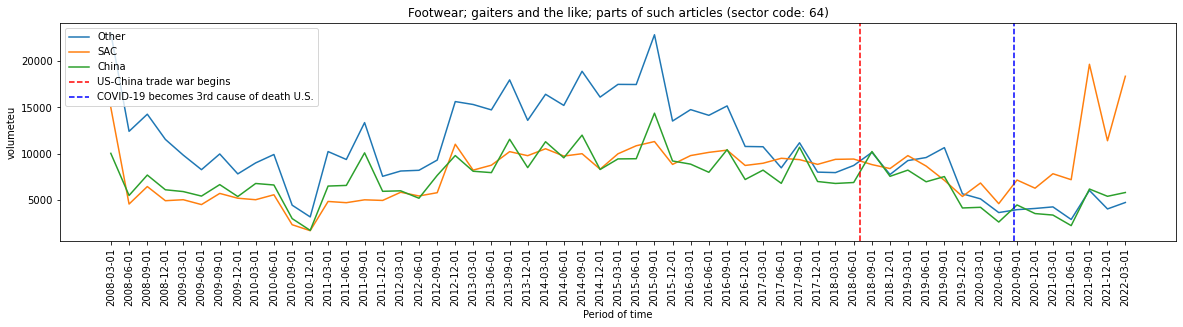

 12%|██████████▌                                                                         | 1/8 [00:20<02:21, 20.24s/it]

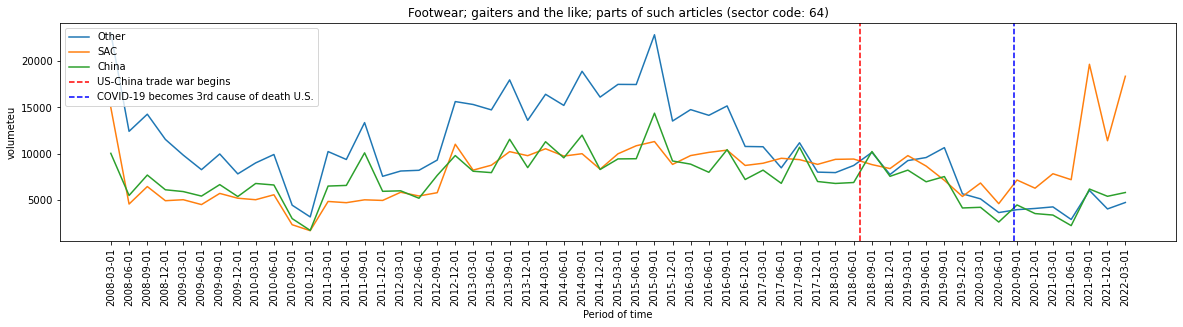

 25%|█████████████████████                                                               | 2/8 [00:41<02:06, 21.11s/it]

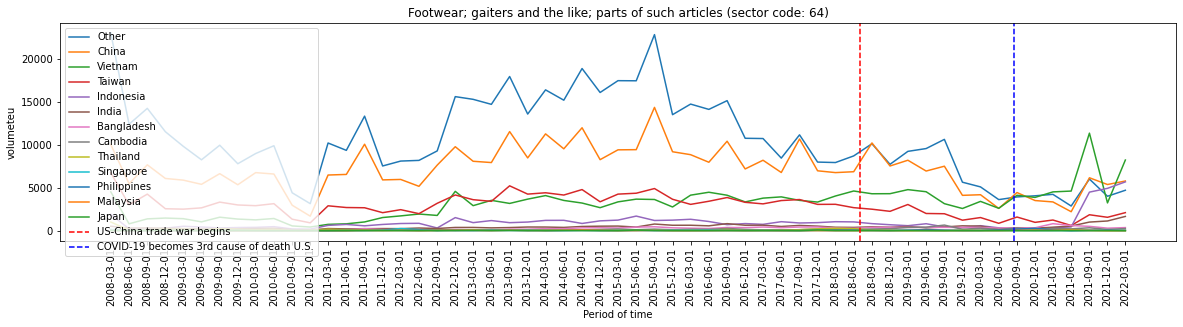

 38%|███████████████████████████████▌                                                    | 3/8 [01:03<01:46, 21.32s/it]

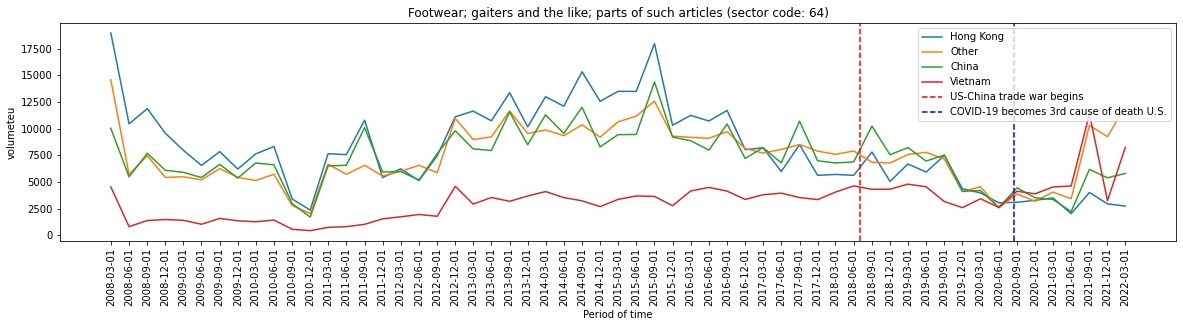

 50%|██████████████████████████████████████████                                          | 4/8 [01:23<01:23, 20.83s/it]

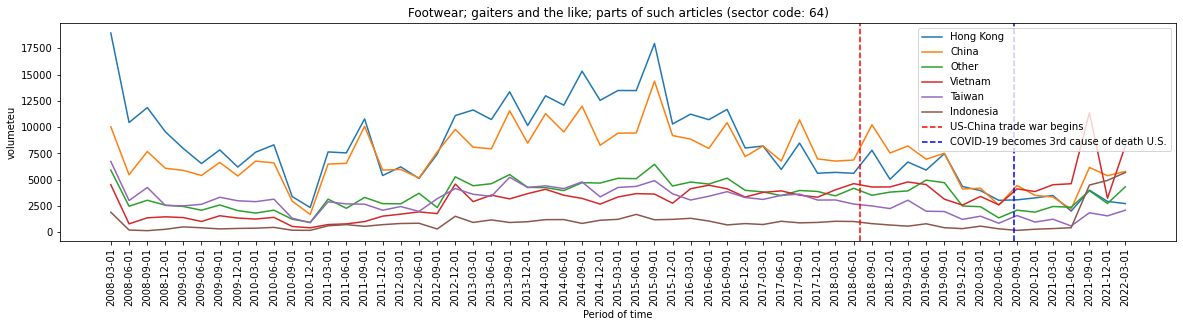

 62%|████████████████████████████████████████████████████▌                               | 5/8 [01:43<01:01, 20.38s/it]

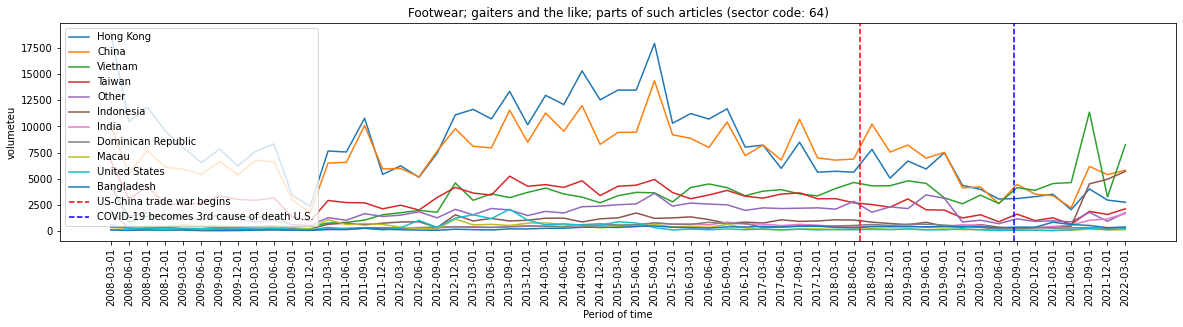

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [02:03<00:40, 20.19s/it]

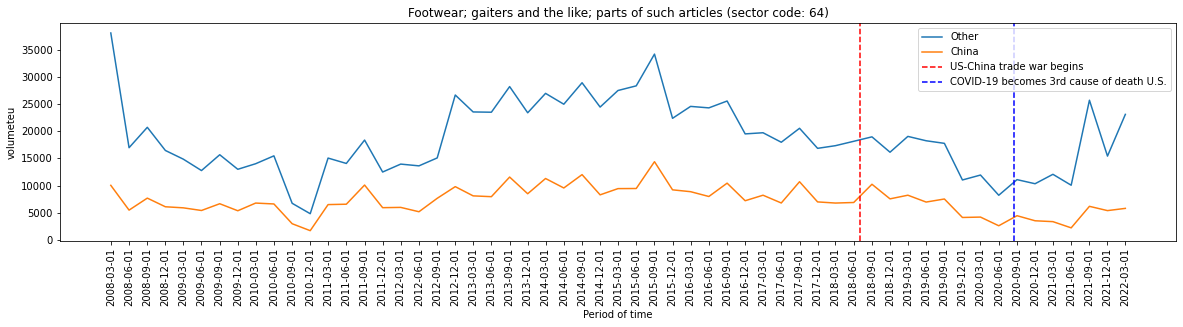

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [02:23<00:20, 20.16s/it]

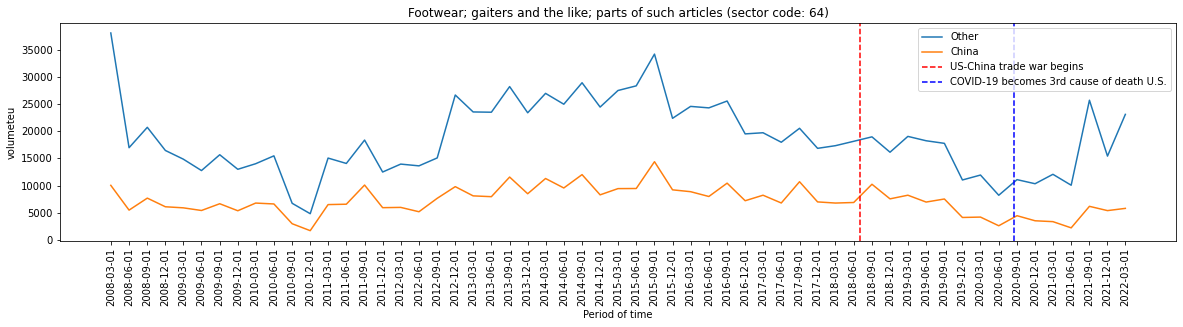

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:42<00:00, 20.35s/it]


In [23]:
code2 = '64'

code2_name = hscode2[code2]
codes6 = get_sector_list(code2)

print(code2_name)

plots = get_plot_dict(codes6, output)

for i in tqdm(list(range(1,8+1))): 
    get_plot(codes6, plots[i]['country_list'], plots[i]['aggr_country'], plots[i]['aggr_country_name'], 
             output = 'volumeteu', 
             title = code2_name + ' (sector code: ' + code2 + ')', 
             period = plots[i]['period'],
             save_as = os.path.join('paper', 'plots', code2 + '_' + str(plots[i]['plot_N'])),
             figsize=[4, 20])

Electrical machinery and equipment and parts thereof; sound recorders and reproducers; television image and sound recorders and reproducers, parts and accessories of such articles


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

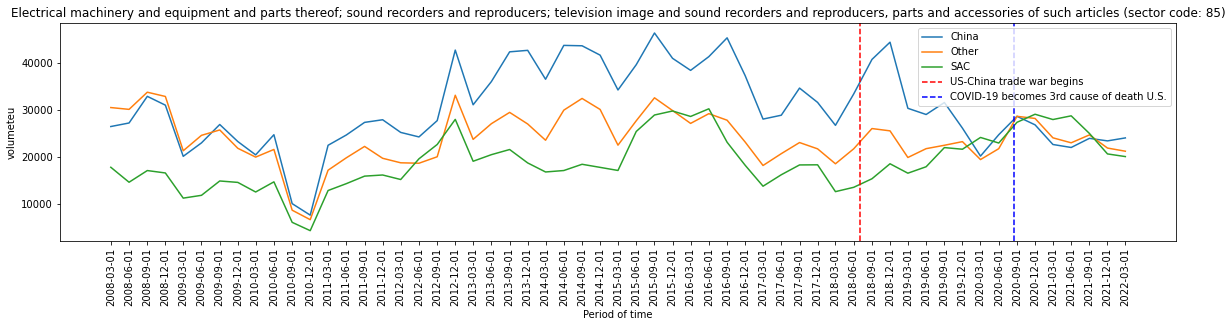

 12%|██████████▌                                                                         | 1/8 [00:30<03:34, 30.62s/it]

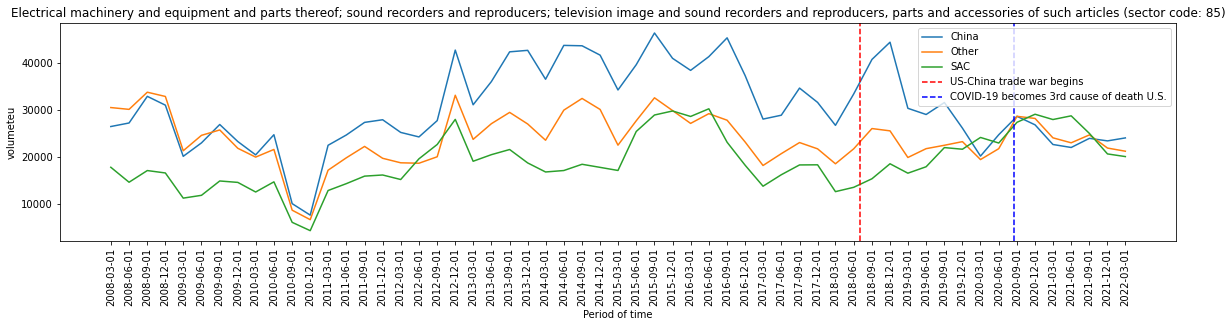

 25%|█████████████████████                                                               | 2/8 [00:59<02:56, 29.43s/it]

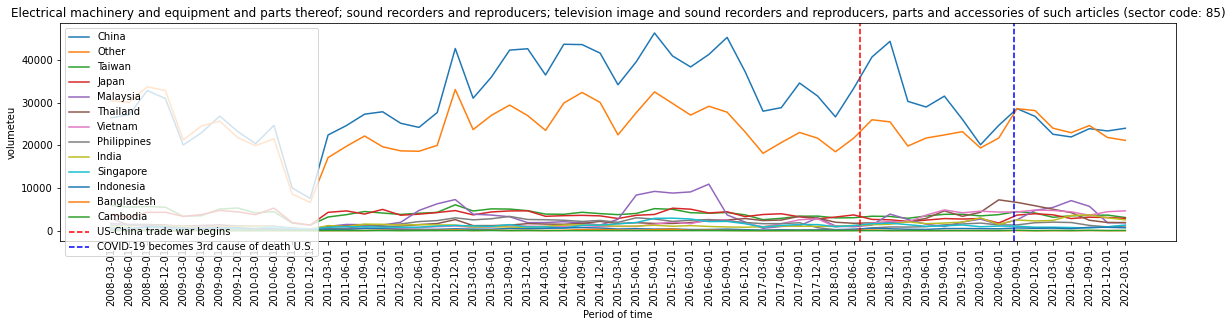

 38%|███████████████████████████████▌                                                    | 3/8 [01:30<02:31, 30.31s/it]

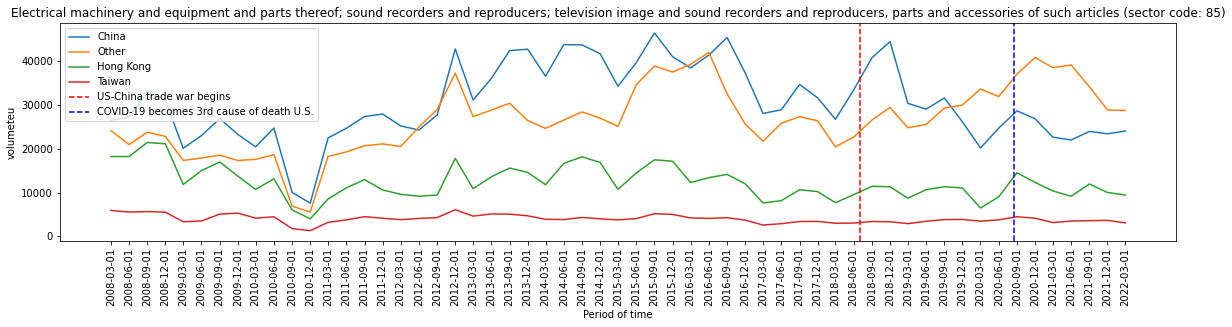

 50%|██████████████████████████████████████████                                          | 4/8 [01:57<01:55, 28.94s/it]

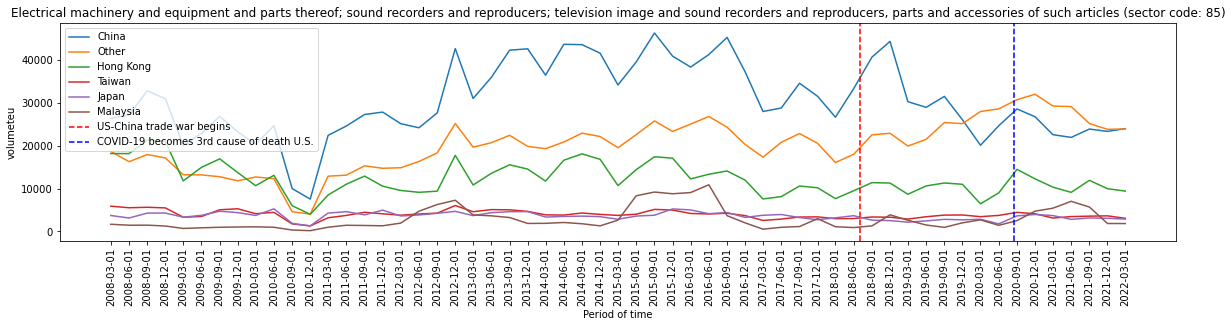

 62%|████████████████████████████████████████████████████▌                               | 5/8 [02:26<01:26, 28.88s/it]

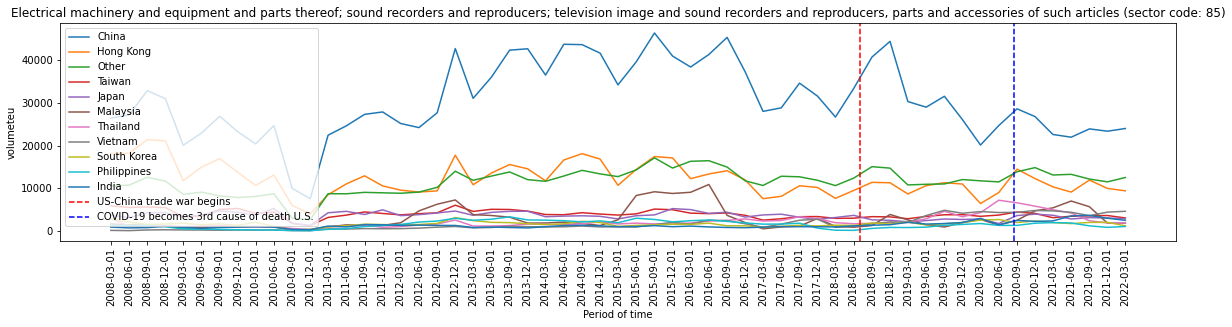

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [02:56<00:58, 29.36s/it]

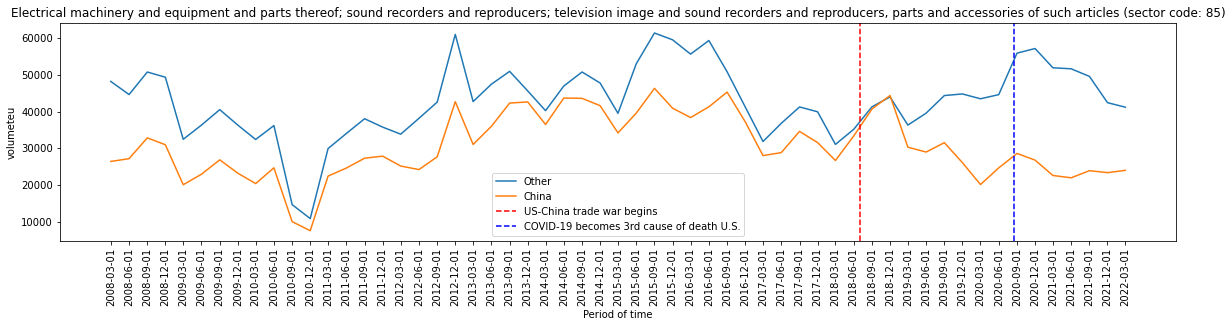

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [03:24<00:28, 28.87s/it]

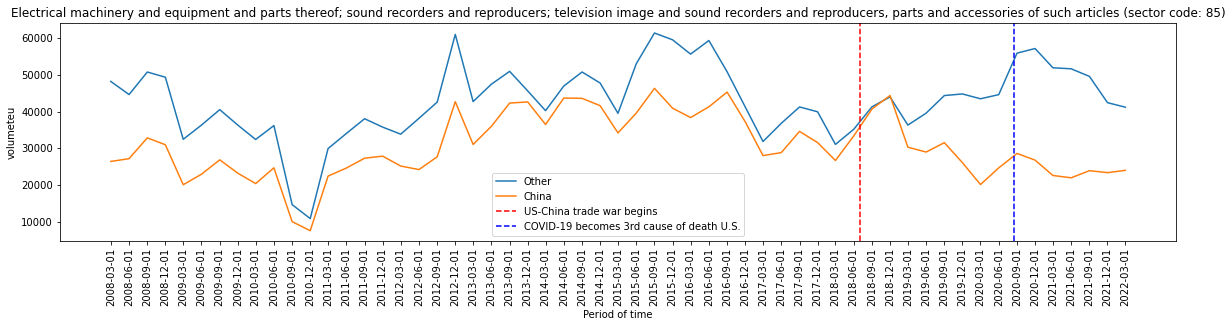

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:51<00:00, 28.98s/it]


In [24]:
code2 = '85'

code2_name = hscode2[code2]
codes6 = get_sector_list(code2)

print(code2_name)

plots = get_plot_dict(codes6, output)

for i in tqdm(list(range(1,8+1))): 
    get_plot(codes6, plots[i]['country_list'], plots[i]['aggr_country'], plots[i]['aggr_country_name'], 
             output = 'volumeteu', 
             title = code2_name + ' (sector code: ' + code2 + ')', 
             period = plots[i]['period'],
             save_as = os.path.join('paper', 'plots', code2 + '_' + str(plots[i]['plot_N'])),
             figsize=[4, 20])

Furniture; bedding, mattresses, mattress supports, cushions and similar stuffed furnishings; lamps and lighting fittings, n.e.s.; illuminated signs, illuminated name


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

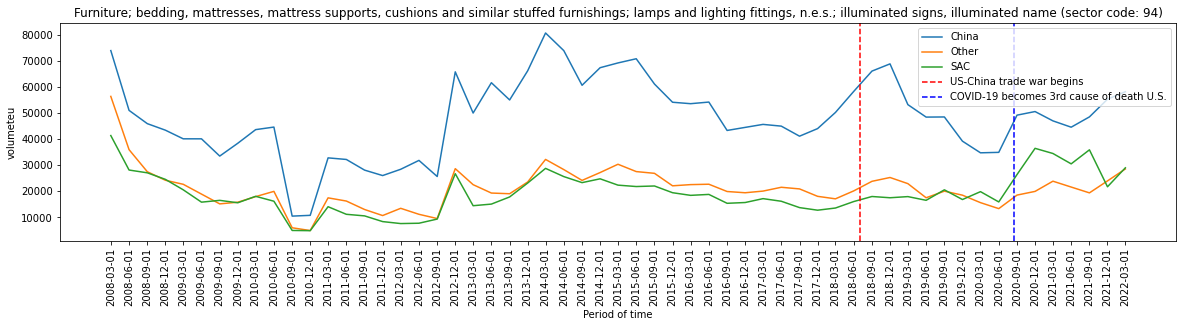

 12%|██████████▌                                                                         | 1/8 [00:28<03:17, 28.19s/it]

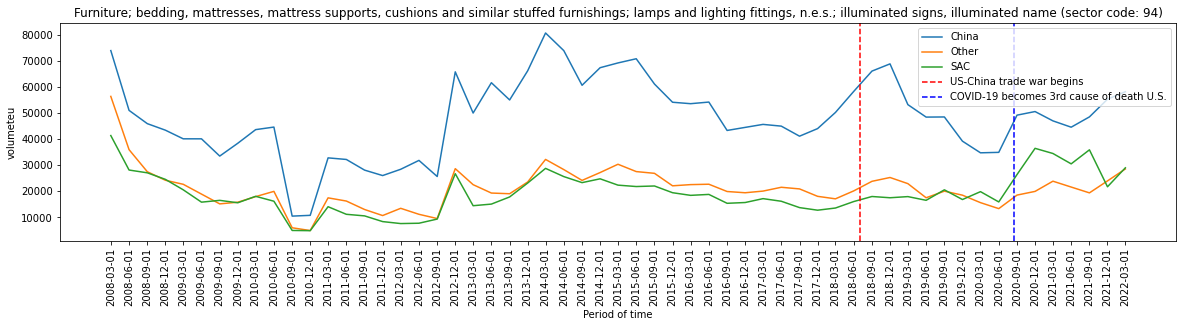

 25%|█████████████████████                                                               | 2/8 [00:52<02:36, 26.03s/it]

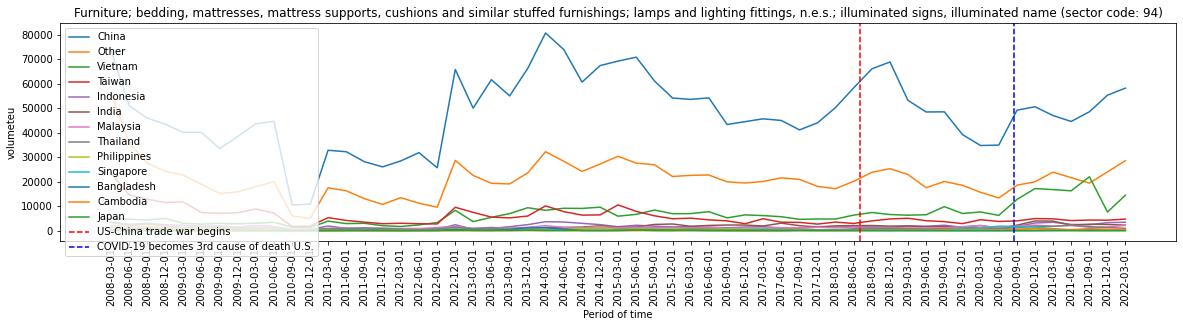

 38%|███████████████████████████████▌                                                    | 3/8 [01:18<02:10, 26.00s/it]

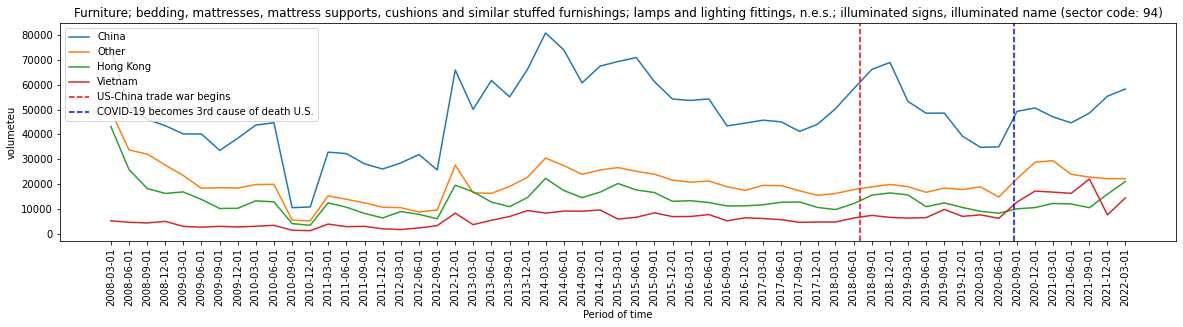

 50%|██████████████████████████████████████████                                          | 4/8 [01:44<01:42, 25.75s/it]

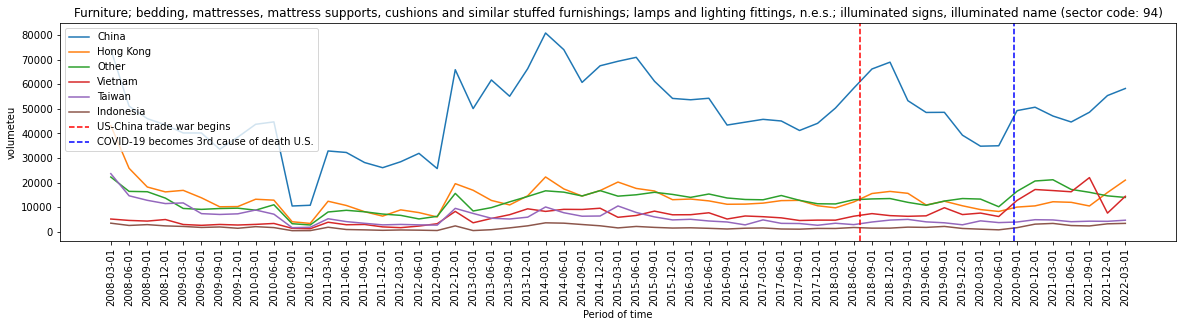

 62%|████████████████████████████████████████████████████▌                               | 5/8 [02:09<01:17, 25.76s/it]

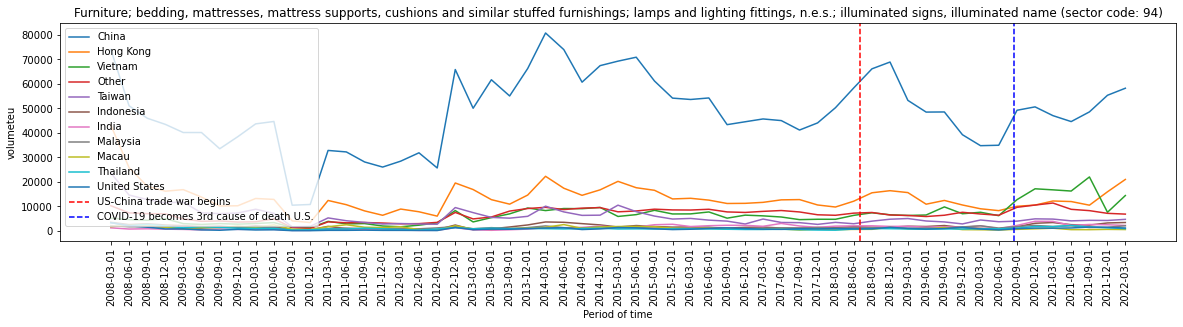

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [02:34<00:51, 25.51s/it]

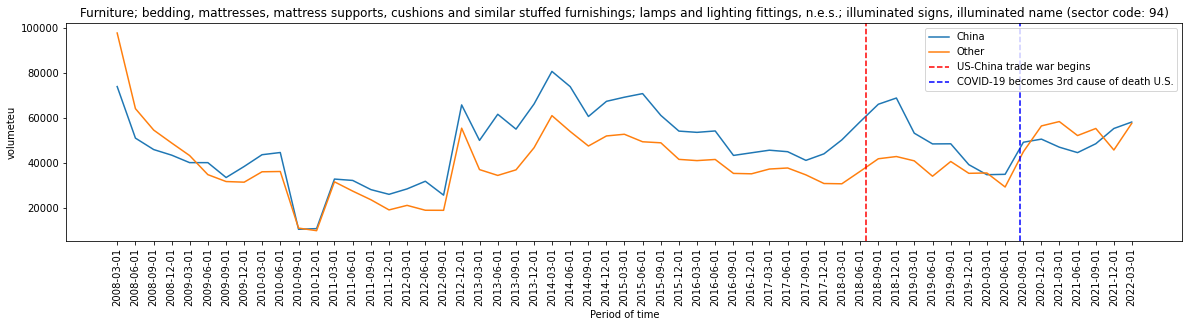

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [03:03<00:26, 26.48s/it]

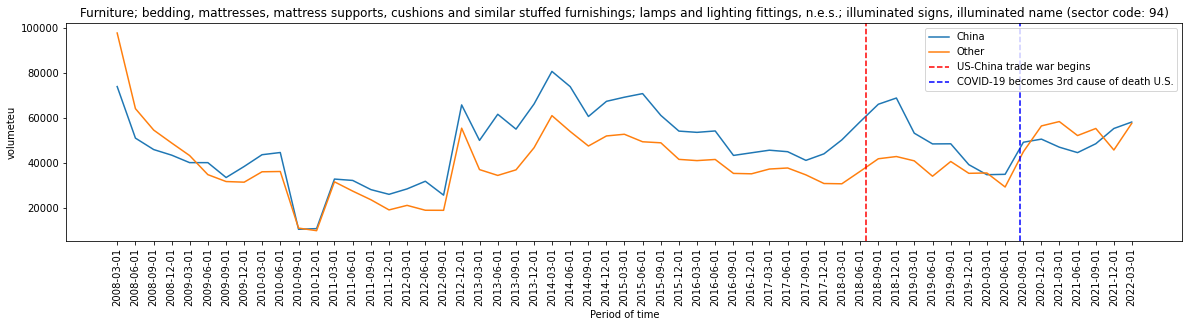

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:32<00:00, 26.57s/it]


In [25]:
code2 = '94'

code2_name = hscode2[code2]
codes6 = get_sector_list(code2)

print(code2_name)

plots = get_plot_dict(codes6, output)

for i in tqdm(list(range(1,8+1))): 
    get_plot(codes6, plots[i]['country_list'], plots[i]['aggr_country'], plots[i]['aggr_country_name'], 
             output = 'volumeteu', 
             title = code2_name + ' (sector code: ' + code2 + ')', 
             period = plots[i]['period'],
             save_as = os.path.join('paper', 'plots', code2 + '_' + str(plots[i]['plot_N'])),
             figsize=[4, 20])

Textiles, made up articles; sets; worn clothing and worn textile articles; rags


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

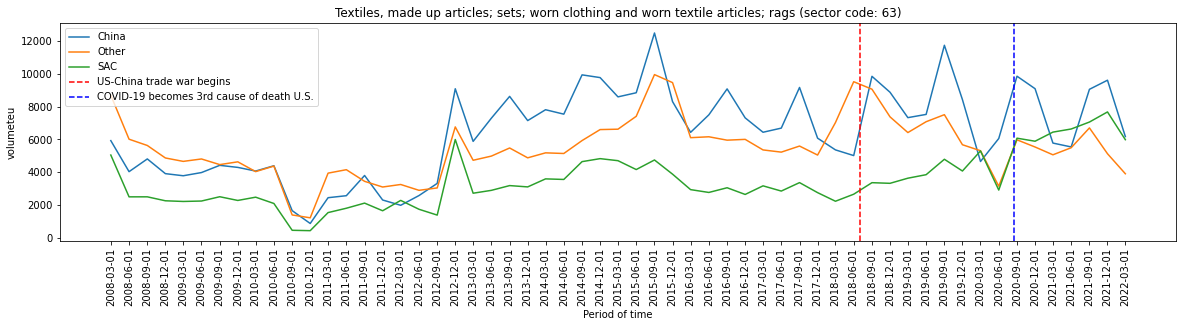

 12%|██████████▌                                                                         | 1/8 [00:18<02:12, 18.87s/it]

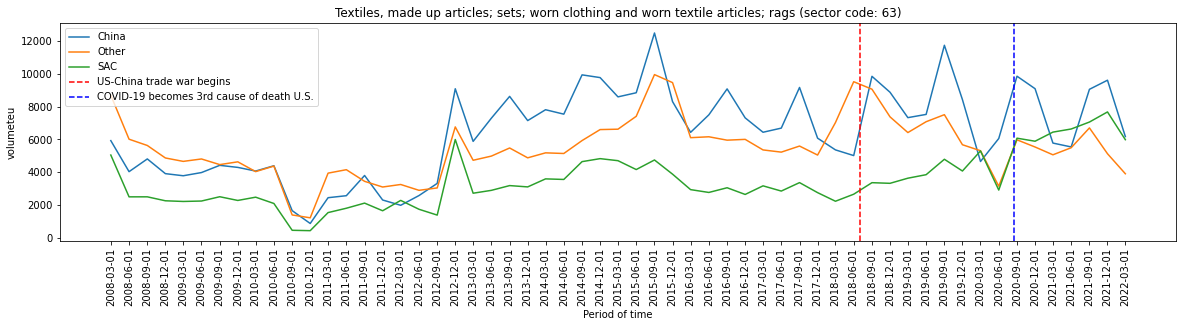

 25%|█████████████████████                                                               | 2/8 [00:42<02:08, 21.47s/it]

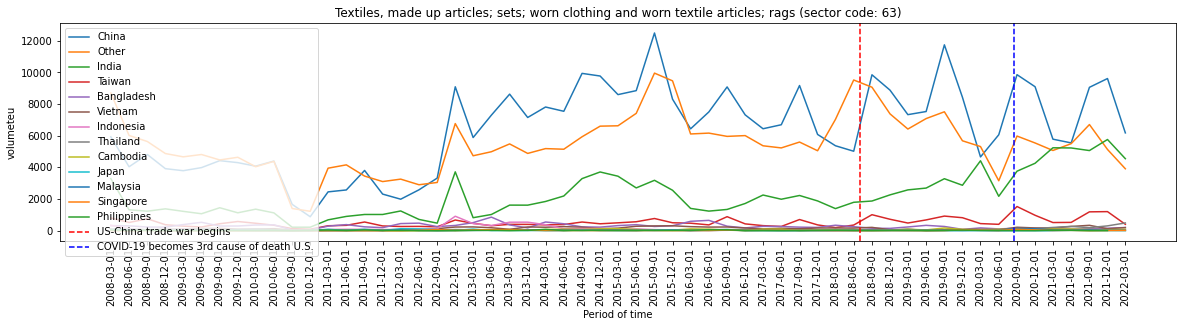

 38%|███████████████████████████████▌                                                    | 3/8 [01:02<01:44, 20.91s/it]

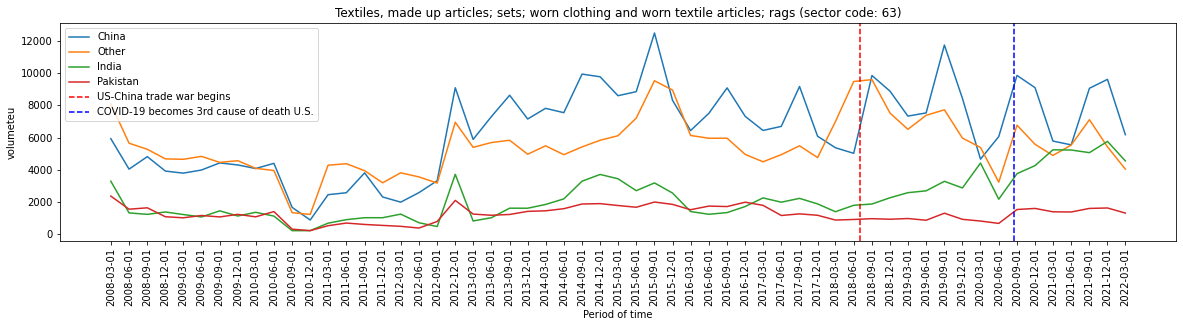

 50%|██████████████████████████████████████████                                          | 4/8 [01:21<01:21, 20.32s/it]

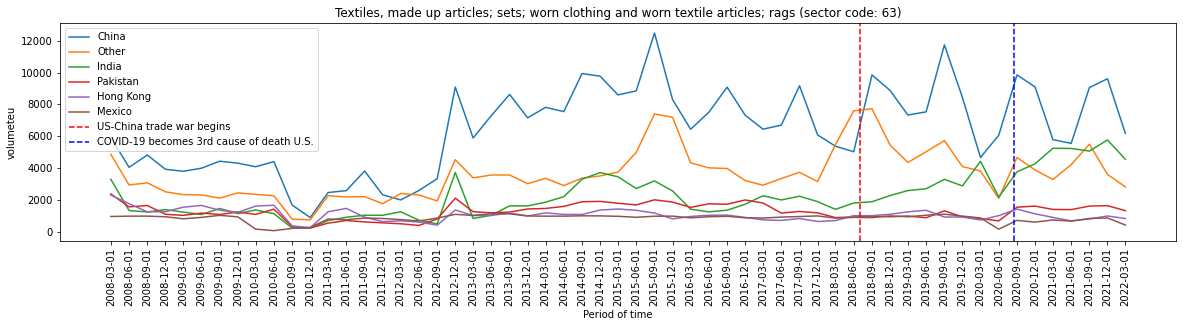

 62%|████████████████████████████████████████████████████▌                               | 5/8 [01:42<01:00, 20.31s/it]

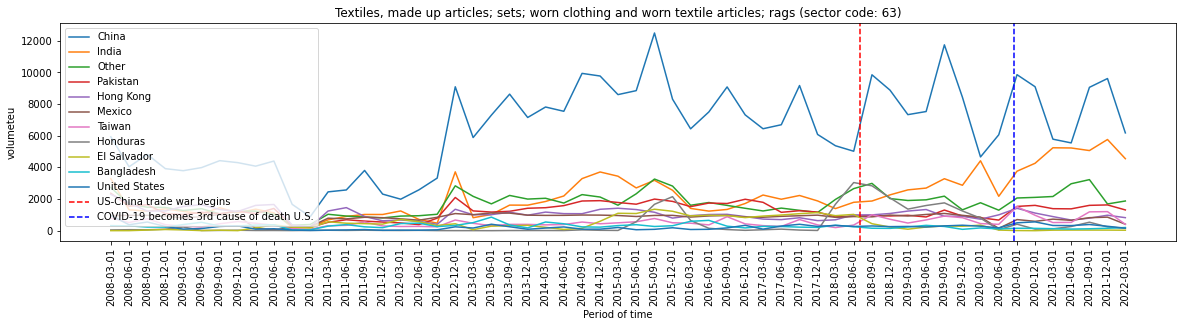

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [02:01<00:40, 20.16s/it]

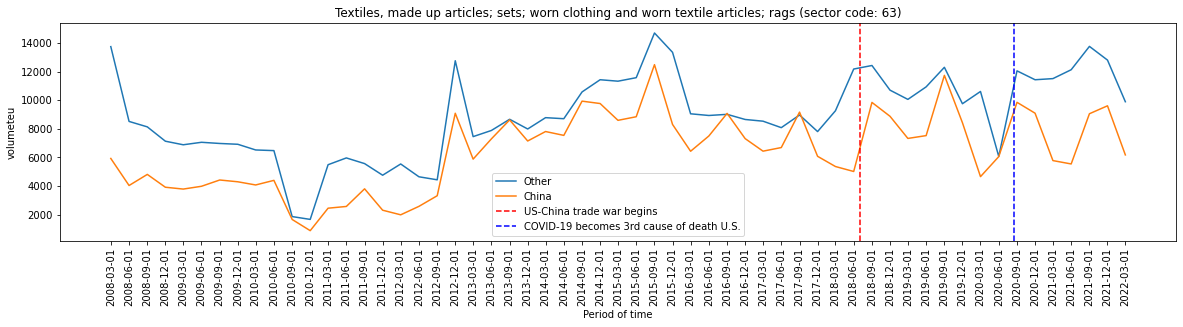

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [02:21<00:19, 19.98s/it]

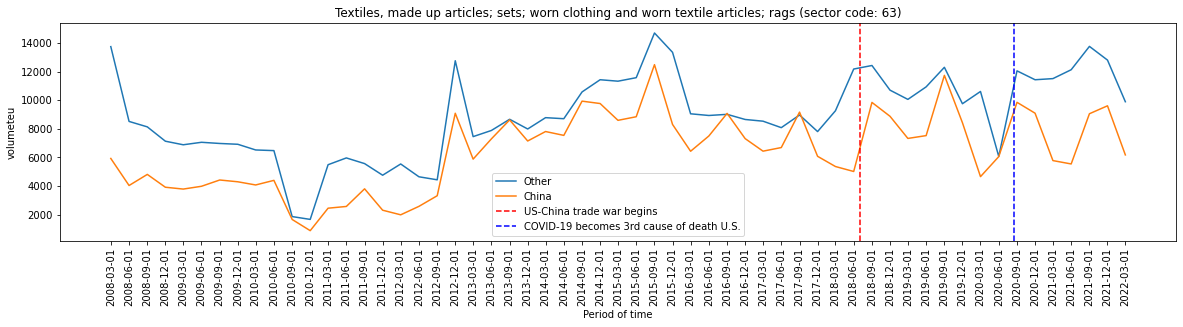

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:41<00:00, 20.15s/it]


In [26]:
code2 = '63'

code2_name = hscode2[code2]
codes6 = get_sector_list(code2)

print(code2_name)

plots = get_plot_dict(codes6, output)

for i in tqdm(list(range(1,8+1))): 
    get_plot(codes6, plots[i]['country_list'], plots[i]['aggr_country'], plots[i]['aggr_country_name'], 
             output = 'volumeteu', 
             title = code2_name + ' (sector code: ' + code2 + ')', 
             period = plots[i]['period'],
             save_as = os.path.join('paper', 'plots', code2 + '_' + str(plots[i]['plot_N'])),
             figsize=[4, 20])

Apparel and clothing accessories; not knitted or crocheted


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

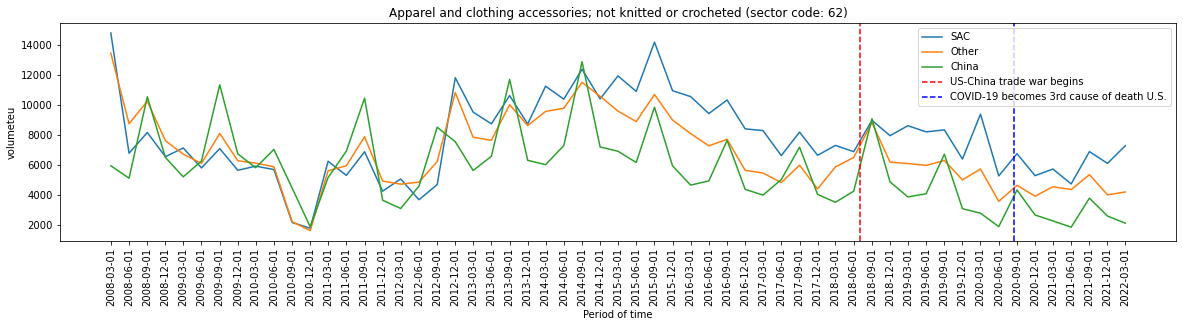

 12%|██████████▌                                                                         | 1/8 [00:22<02:36, 22.40s/it]

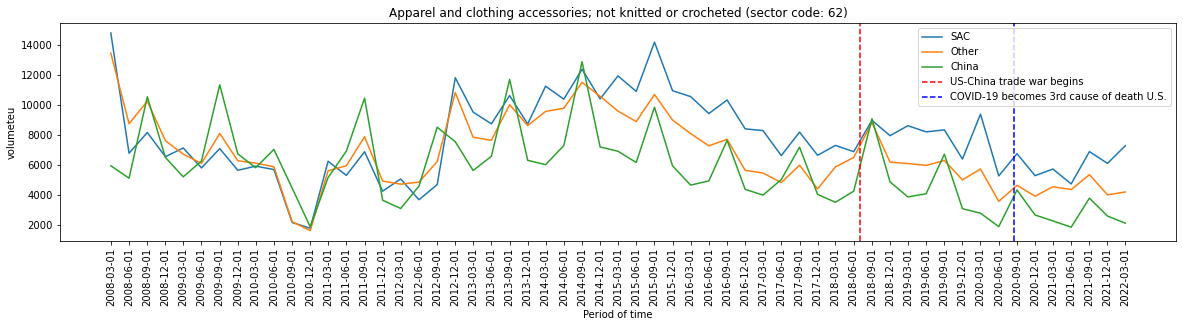

 25%|█████████████████████                                                               | 2/8 [00:45<02:16, 22.77s/it]

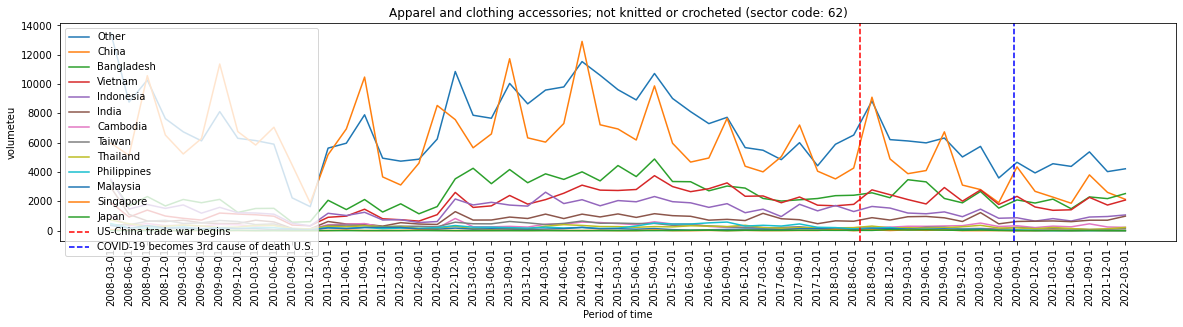

 38%|███████████████████████████████▌                                                    | 3/8 [01:08<01:55, 23.02s/it]

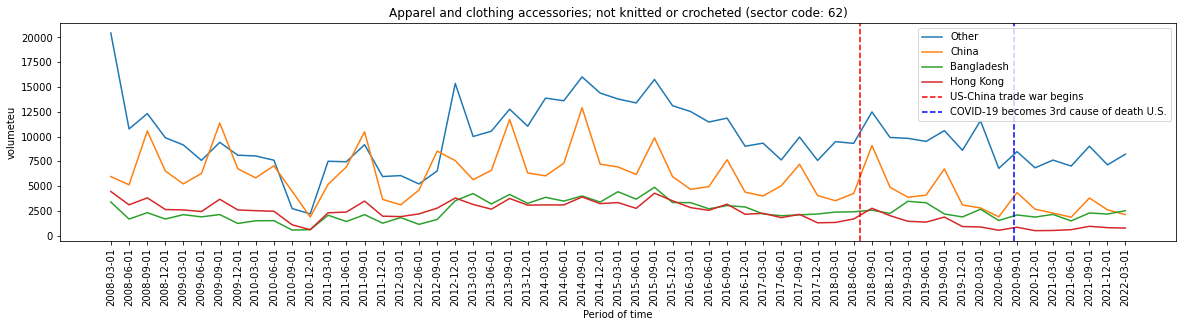

 50%|██████████████████████████████████████████                                          | 4/8 [01:32<01:32, 23.19s/it]

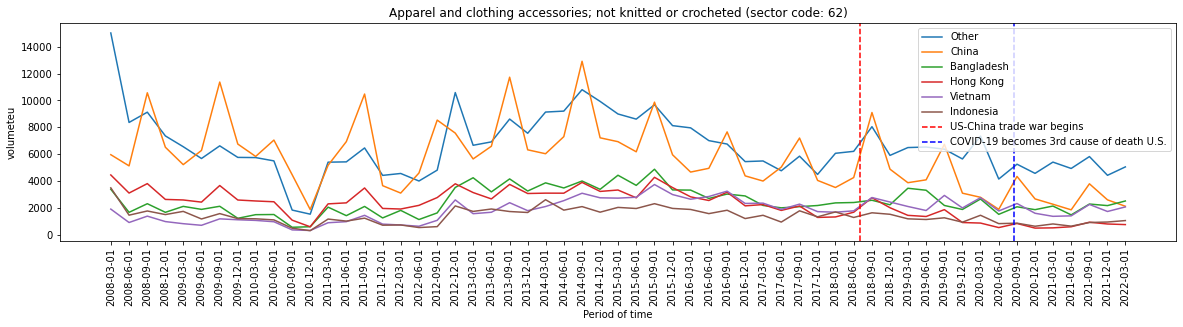

 62%|████████████████████████████████████████████████████▌                               | 5/8 [01:55<01:09, 23.19s/it]

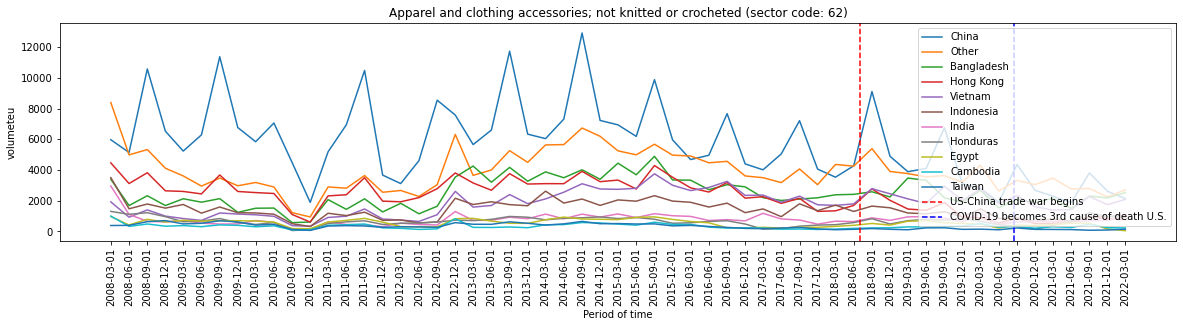

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [02:18<00:46, 23.04s/it]

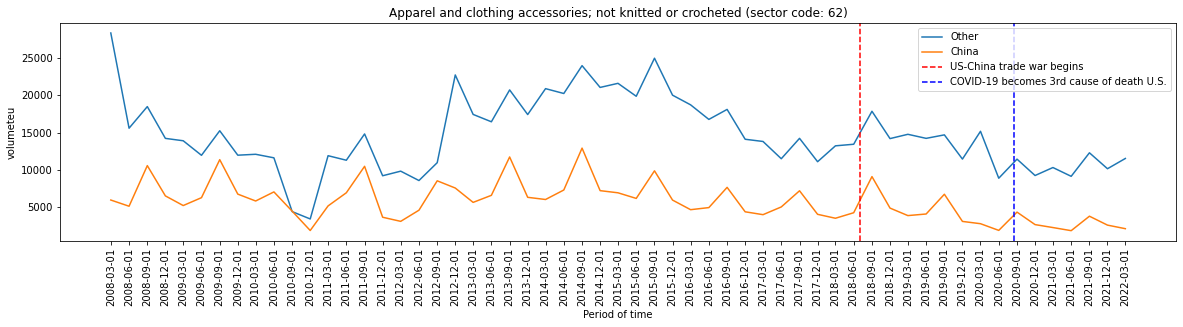

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [02:40<00:22, 22.68s/it]

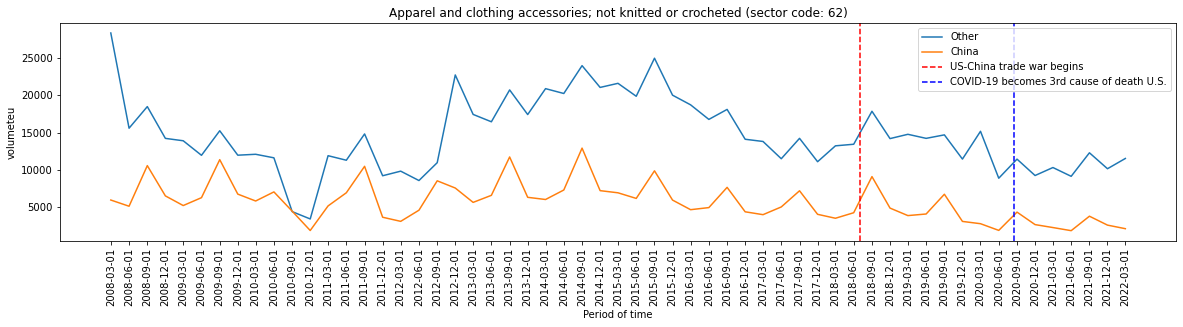

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:03<00:00, 22.99s/it]


In [27]:
code2 = '62'

code2_name = hscode2[code2]
codes6 = get_sector_list(code2)

print(code2_name)

plots = get_plot_dict(codes6, output)

for i in tqdm(list(range(1,8+1))): 
    get_plot(codes6, plots[i]['country_list'], plots[i]['aggr_country'], plots[i]['aggr_country_name'], 
             output = 'volumeteu', 
             title = code2_name + ' (sector code: ' + code2 + ')', 
             period = plots[i]['period'],
             save_as = os.path.join('paper', 'plots', code2 + '_' + str(plots[i]['plot_N'])),
             figsize=[4, 20])

Apparel and clothing accessories; knitted or crocheted


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

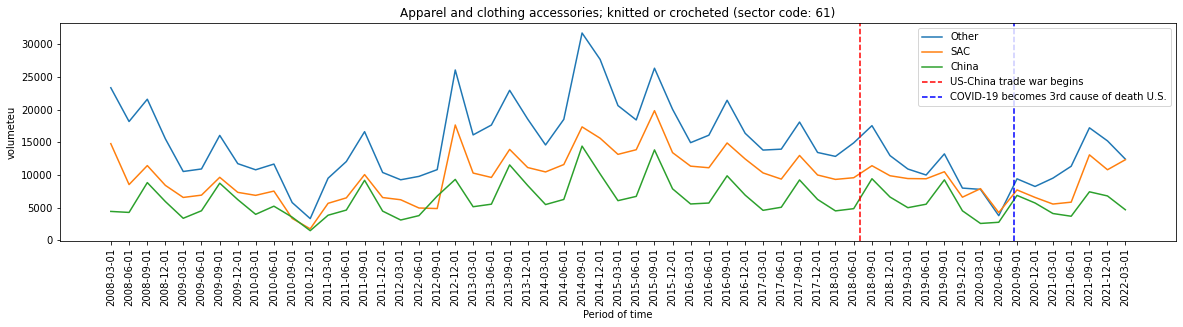

 12%|██████████▌                                                                         | 1/8 [00:23<02:47, 23.97s/it]

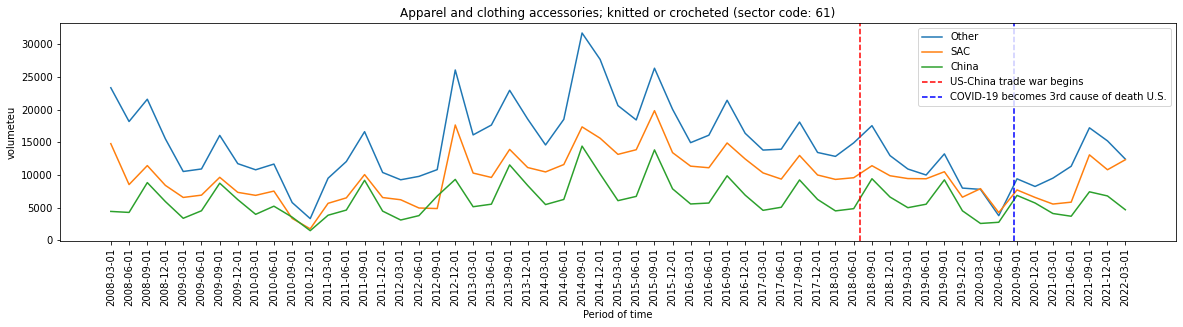

 25%|█████████████████████                                                               | 2/8 [00:47<02:22, 23.75s/it]

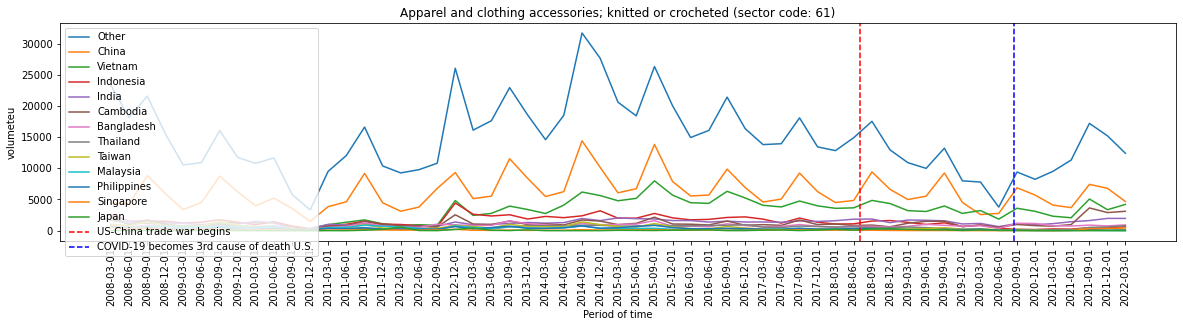

 38%|███████████████████████████████▌                                                    | 3/8 [01:14<02:05, 25.07s/it]

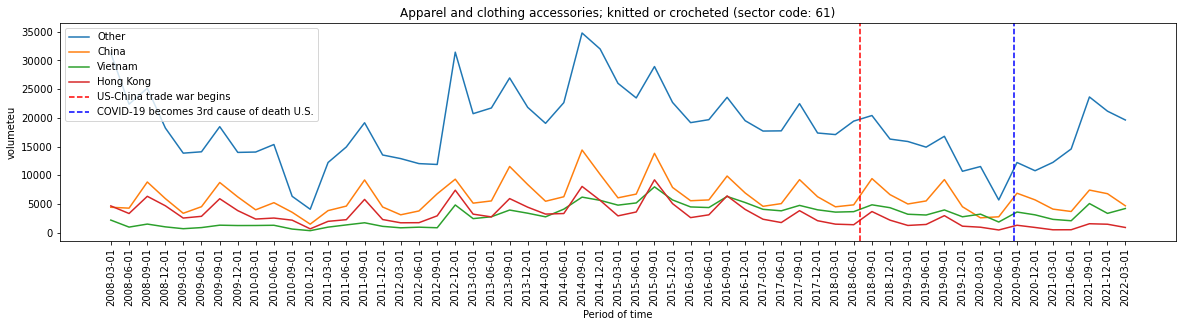

 50%|██████████████████████████████████████████                                          | 4/8 [01:39<01:40, 25.10s/it]

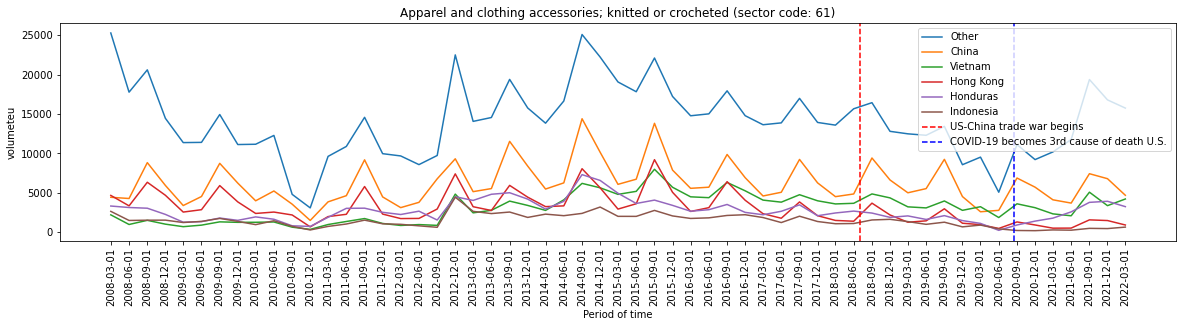

 62%|████████████████████████████████████████████████████▌                               | 5/8 [02:02<01:13, 24.39s/it]

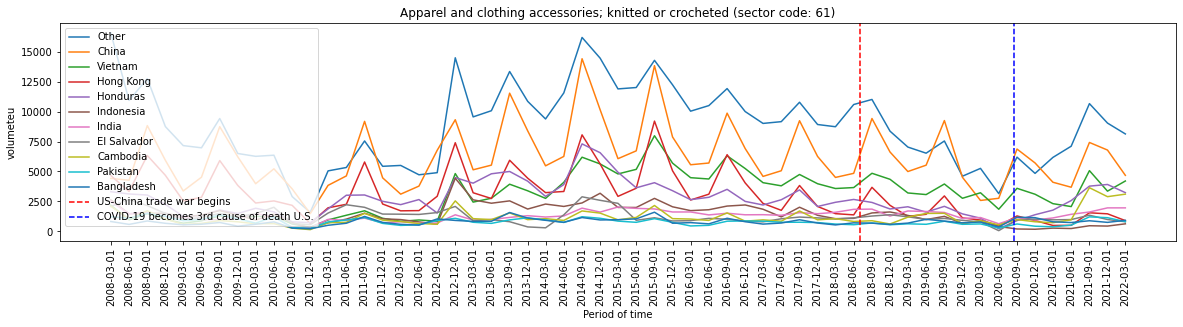

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [02:29<00:50, 25.28s/it]

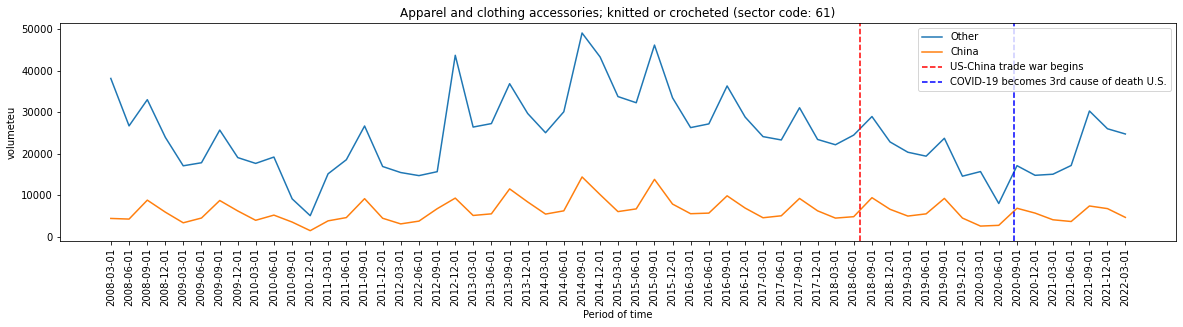

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [02:53<00:24, 24.88s/it]

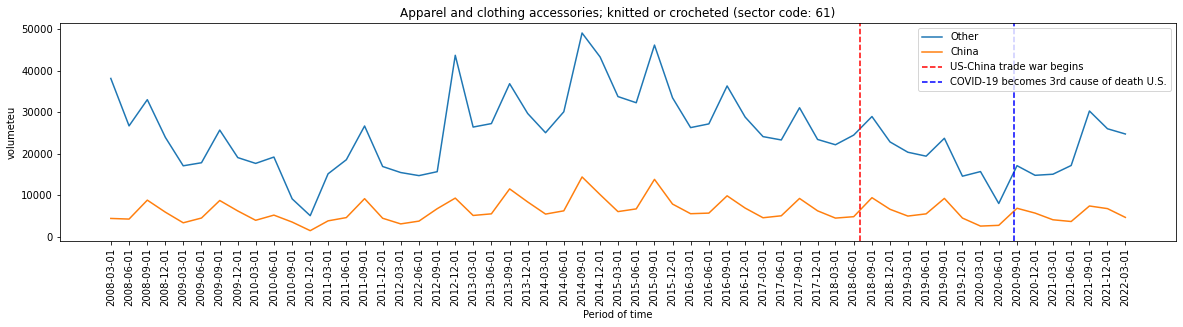

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:16<00:00, 24.55s/it]


In [28]:
code2 = '61'

code2_name = hscode2[code2]
codes6 = get_sector_list(code2)

print(code2_name)

plots = get_plot_dict(codes6, output)

for i in tqdm(list(range(1,8+1))): 
    get_plot(codes6, plots[i]['country_list'], plots[i]['aggr_country'], plots[i]['aggr_country_name'], 
             output = 'volumeteu', 
             title = code2_name + ' (sector code: ' + code2 + ')', 
             period = plots[i]['period'],
             save_as = os.path.join('paper', 'plots', code2 + '_' + str(plots[i]['plot_N'])),
             figsize=[4, 20])

Textile fabrics; impregnated, coated, covered or laminated; textile articles of a kind suitable for industrial use


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

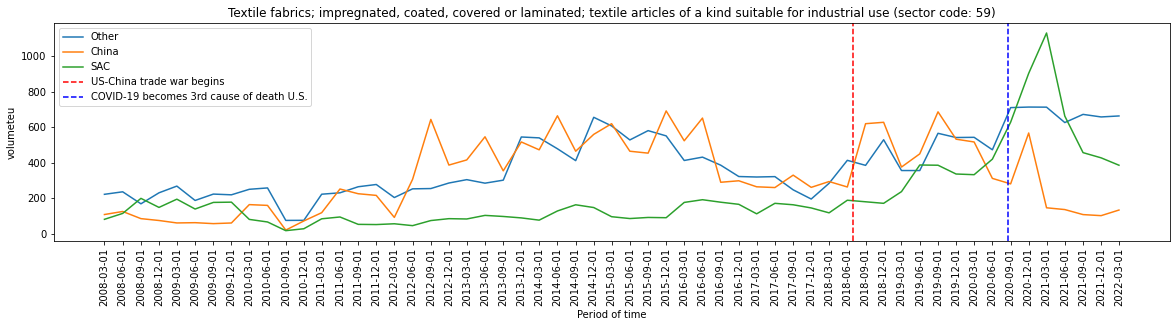

 12%|██████████▌                                                                         | 1/8 [00:19<02:18, 19.75s/it]

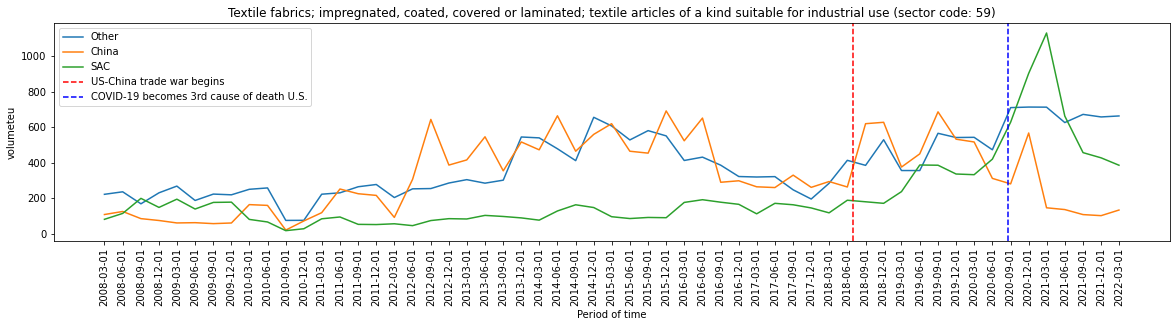

 25%|█████████████████████                                                               | 2/8 [00:38<01:55, 19.29s/it]

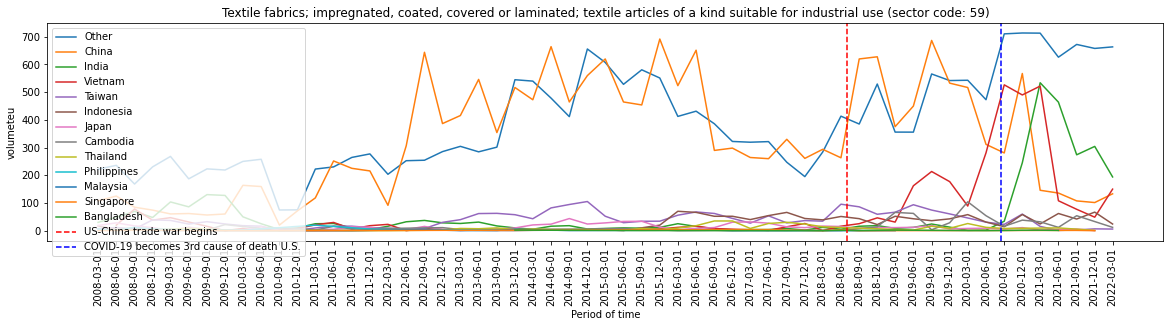

 38%|███████████████████████████████▌                                                    | 3/8 [00:58<01:36, 19.34s/it]

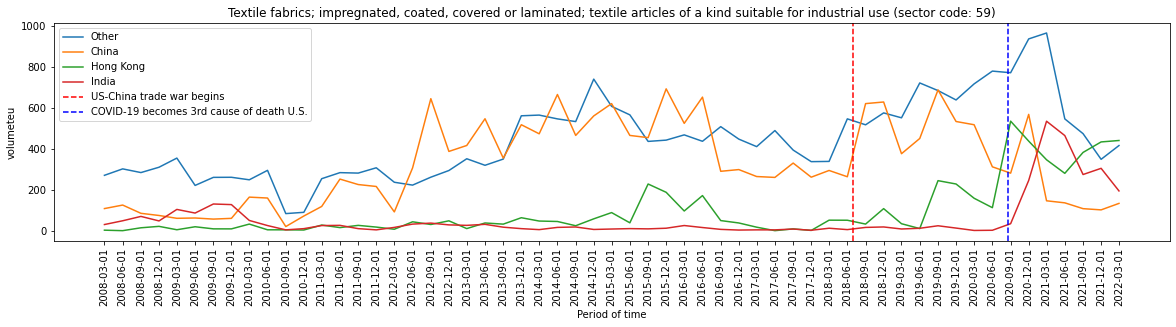

 50%|██████████████████████████████████████████                                          | 4/8 [01:17<01:17, 19.34s/it]

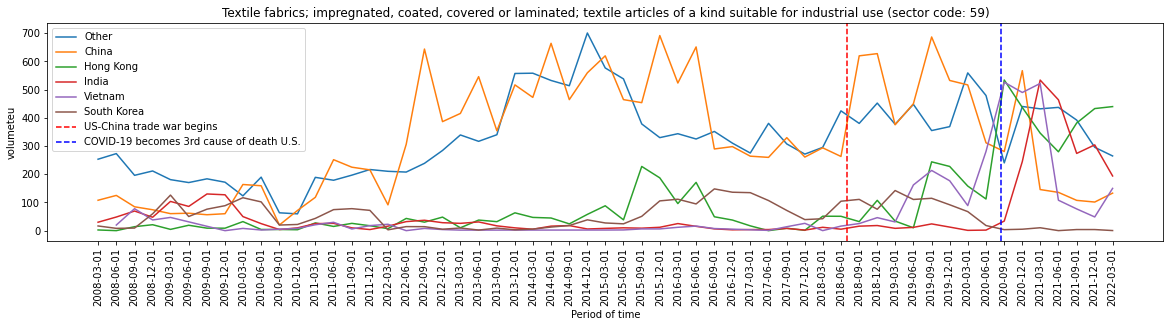

 62%|████████████████████████████████████████████████████▌                               | 5/8 [01:40<01:01, 20.51s/it]

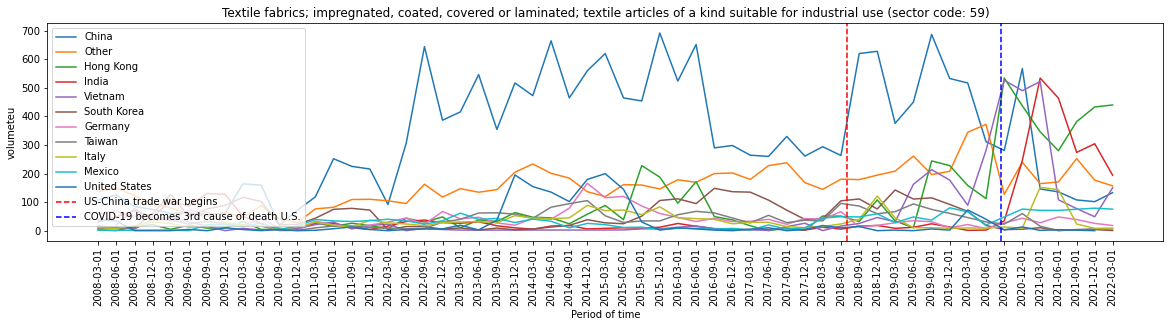

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [01:58<00:39, 19.92s/it]

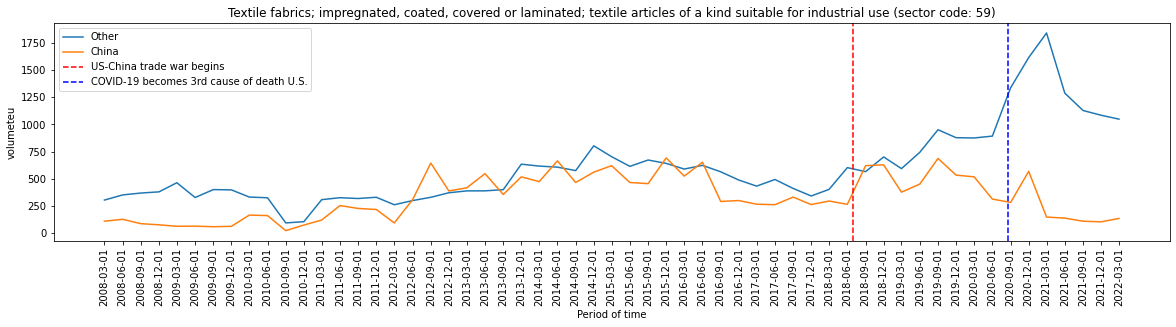

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [02:18<00:19, 19.78s/it]

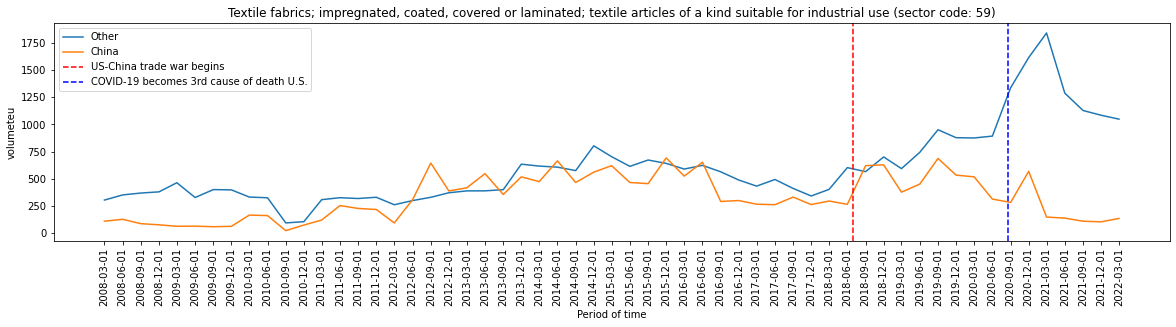

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:36<00:00, 19.62s/it]


In [29]:
code2 = '59'

code2_name = hscode2[code2]
codes6 = get_sector_list(code2)

print(code2_name)

plots = get_plot_dict(codes6, output)

for i in tqdm(list(range(1,8+1))): 
    get_plot(codes6, plots[i]['country_list'], plots[i]['aggr_country'], plots[i]['aggr_country_name'], 
             output = 'volumeteu', 
             title = code2_name + ' (sector code: ' + code2 + ')', 
             period = plots[i]['period'],
             save_as = os.path.join('paper', 'plots', code2 + '_' + str(plots[i]['plot_N'])),
             figsize=[4, 20])

Toys, games and sports requisites; parts and accessories thereof


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

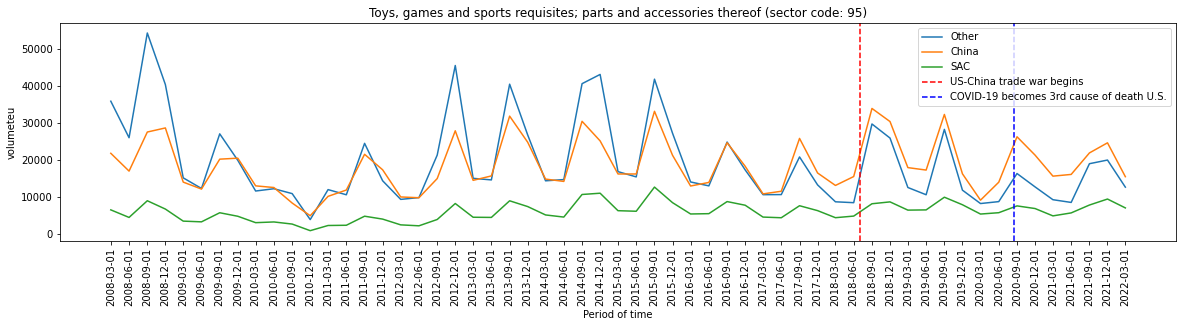

 12%|██████████▌                                                                         | 1/8 [00:21<02:30, 21.48s/it]

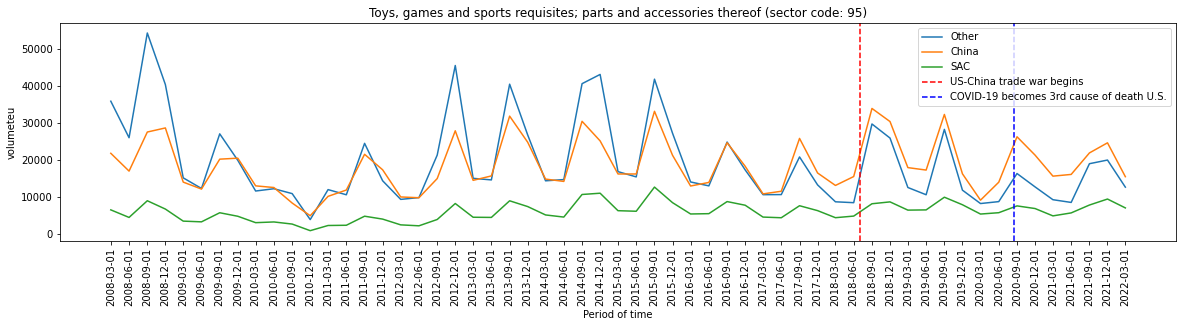

 25%|█████████████████████                                                               | 2/8 [00:42<02:05, 20.99s/it]

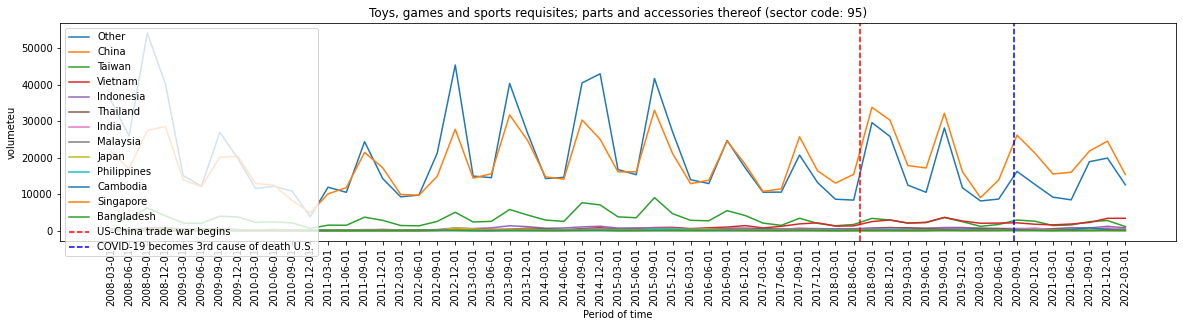

 38%|███████████████████████████████▌                                                    | 3/8 [01:03<01:46, 21.24s/it]

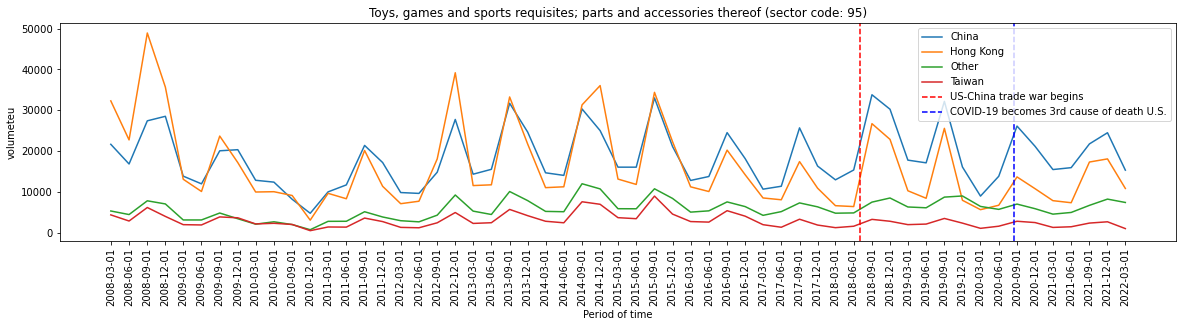

 50%|██████████████████████████████████████████                                          | 4/8 [01:25<01:25, 21.39s/it]

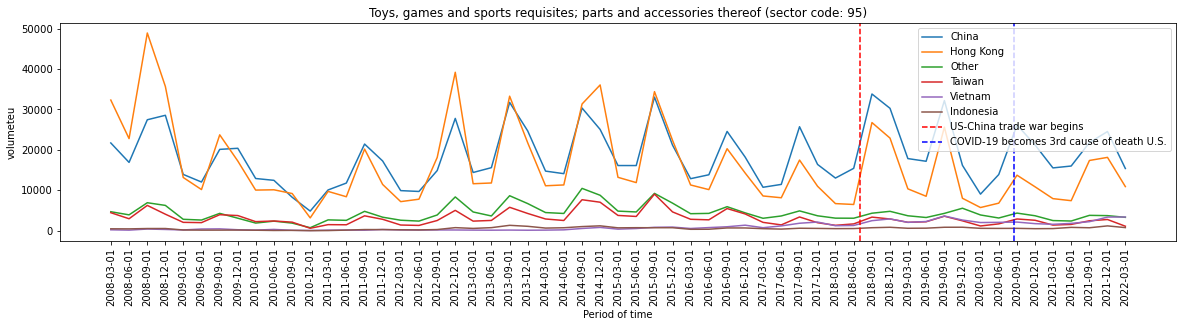

 62%|████████████████████████████████████████████████████▌                               | 5/8 [01:46<01:04, 21.41s/it]

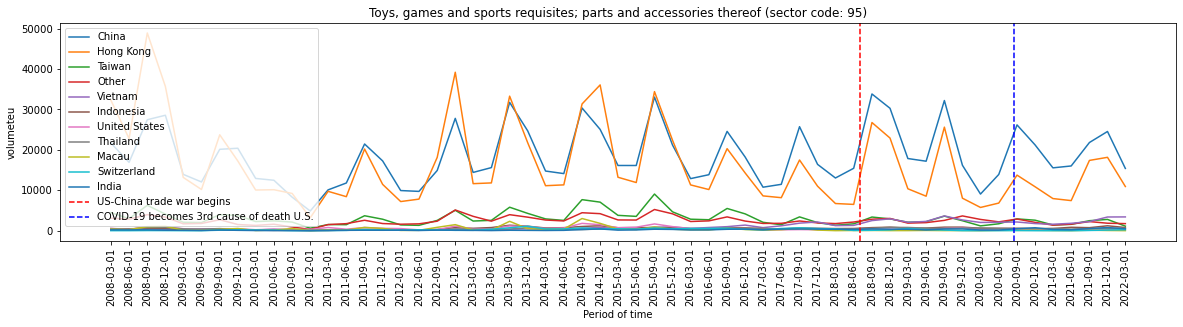

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [02:08<00:42, 21.39s/it]

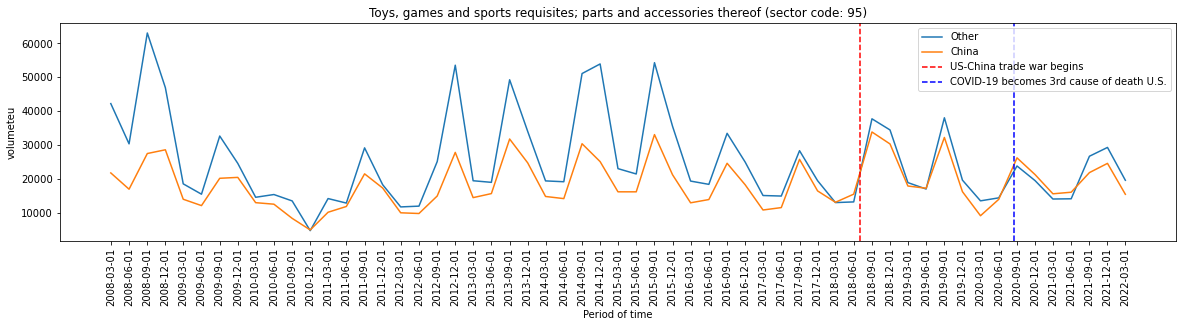

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [02:31<00:21, 21.95s/it]

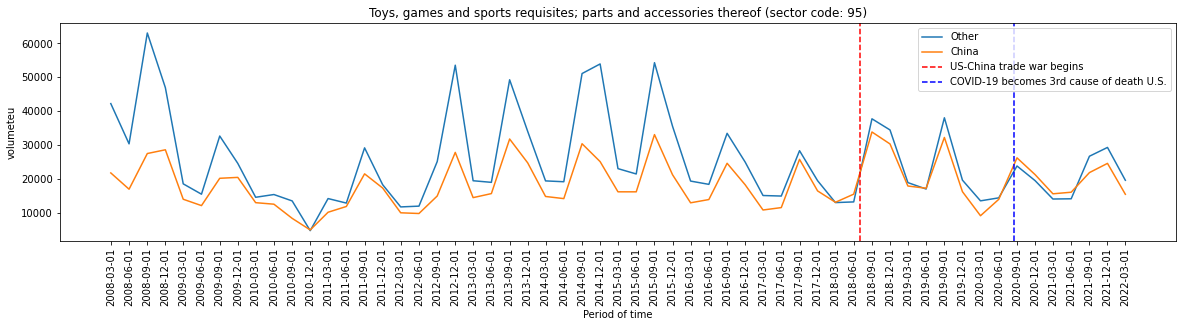

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:53<00:00, 21.74s/it]


In [30]:
code2 = '95'

code2_name = hscode2[code2]
codes6 = get_sector_list(code2)

print(code2_name)

plots = get_plot_dict(codes6, output)

for i in tqdm(list(range(1,8+1))): 
    get_plot(codes6, plots[i]['country_list'], plots[i]['aggr_country'], plots[i]['aggr_country_name'], 
             output = 'volumeteu', 
             title = code2_name + ' (sector code: ' + code2 + ')', 
             period = plots[i]['period'],
             save_as = os.path.join('paper', 'plots', code2 + '_' + str(plots[i]['plot_N'])),
             figsize=[4, 20])